### Load Predefined Probe

In [1]:
import scipy
from numpy import zeros, newaxis
# !pip install pytorch-msssim
from pytorch_msssim import ms_ssim, ssim 
from torchmetrics.image import PeakSignalNoiseRatio
import random

In [3]:
# Load known prode
probe0=scipy.io.loadmat('2d_probe.mat')
probe=probe0['B']
probe.shape

(28, 28)

In [5]:
# !pip install wandb
import wandb
wandb.login()

wandb: Currently logged in as: hungryy. Use `wandb login --relogin` to force relogin


True

In [6]:
def get_tensor(sidelength, name, padding):
    if name == "cameraman":
        img = Image.fromarray(skimage.data.camera()) 
    elif name == "brick":
        img = Image.fromarray(skimage.data.brick())   
    else:
        img = Image.open(name)
    if name == "LenaRGB.bmp":
        img = Grayscale(1)(img)
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Pad(padding, fill=0, padding_mode='constant'),
    ])
    img = transform(img)
    return img

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, Grayscale, Pad
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [8]:
manualSeed = 7383
# manualSeed = random.randint(1, 10000)  # use if you want new results
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  7383


In [9]:
name1 =  "cameraman" # "Barbara.bmp" "Goldhill.bmp" "Peppers.bmp" "cameraman" "brick" "LenaRGB.bmp"
pad = 14 #probe.shape[0]//2
img=get_tensor(256, name1, (pad,pad,pad,pad))
name2 =  "brick" # "Barbara.bmp" "Goldhill.bmp" "Peppers.bmp" "cameraman" "brick" "LenaRGB.bmp"
img2=get_tensor(256, name2, (pad,pad,pad,pad))
# img2 = torch.rot90(img, k=2)

In [10]:
wandb.init(project="pty", name="SIREN")
wandb.watch_called = False

### Ground Truth

In [11]:
Object=torch.complex(img*torch.cos(img2*np.pi),img*torch.sin(img2*np.pi))

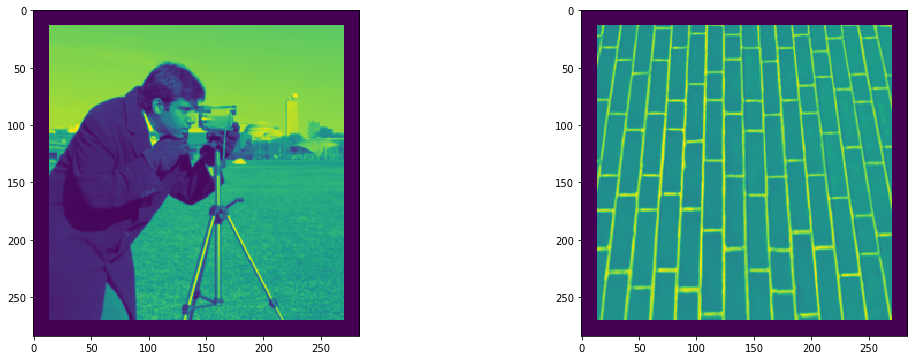

In [12]:
fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].imshow((Object.abs().permute(1,2,0).cpu().detach().numpy()), interpolation='nearest')
axes[1].imshow((Object.angle().permute(1,2,0).cpu().detach().numpy()), interpolation='nearest')

In [13]:
real_density = Object.abs()[:,pad:-pad,pad:-pad]
real_phase = Object.angle()[:,pad:-pad,pad:-pad]/np.pi 

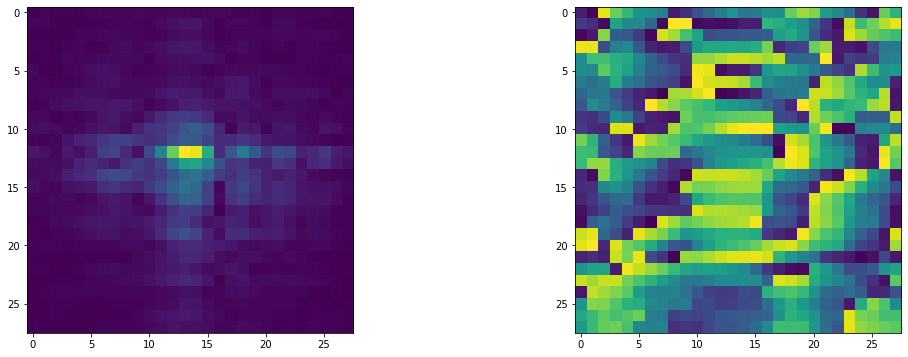

In [14]:
probe=torch.from_numpy(probe)
fig, axes = plt.subplots(1,2, figsize=(18,6))
axes[0].imshow((probe.abs().cpu().detach().numpy()), interpolation='nearest')
axes[1].imshow((probe.angle().cpu().detach().numpy()), interpolation='nearest')

### Simulated Intensity

In [15]:
# pad
# 30% num_scan_v= int(Object.shape[1]/(probeSize * 0.7)) = 256/(28*0.7) = 14 step_scan=19
# 50% num_scan_v= int(Object.shape[1]/(probeSize * 0.5)) = 256/(28*0.5) = 19 step_scan=14
# 70% num_scan_v= int(Object.shape[1]/(probeSize * 0.7)) = 256/(28*0.3) = 32 step_scan=8

scan = []
overlap = 50
if overlap==30:
    coordpara, LR, hf, hl=2, 2*1e-4, 256, 3
elif overlap==50:
    coordpara, LR, hf, hl=2, 4*1e-4, 256, 3
else:
    coordpara, LR, hf, hl= 6, 4*1e-4, 512, 2 
num_scan_v = 19 #vertical 50% overlap
num_scan_h = 19 #horizontal
num_scan = num_scan_v*num_scan_h
step_scan_v = 14 #Object.shape[1]//num_scan_v
step_scan_h = 14 #Object.shape[2]//num_scan_h

positions_v = []
positions_h = []
for i in range(num_scan_v):
    for j in range(num_scan_h):
        positions_v.append(i*step_scan_v)
        positions_h.append(j*step_scan_h)

for i in range(num_scan_v*num_scan_h):
    start_v = max(0, positions_v[i]-probe.shape[0]//2)
    end_v = min(Object.shape[1]-1, positions_v[i]+(probe.shape[0]-probe.shape[0]//2))
    start_h = max(0, positions_h[i]-probe.shape[1]//2)
    end_h = min(Object.shape[2]-1, positions_h[i]+(probe.shape[1]-probe.shape[1]//2))
    img_var_meas = np.multiply(probe[probe.shape[0]-(end_v-start_v):,probe.shape[1]-(end_h-start_h):], Object[0,start_v:end_v,start_h:end_h])
    
    start_v = positions_v[i]
    end_v = positions_v[i]+probe.shape[0]
    start_h = positions_h[i]
    end_h = positions_h[i]+probe.shape[1]
    img_var_meas = np.multiply(probe, Object[0,start_v:end_v,start_h:end_h])
    # absolute valued measurements : y = |A*x|    |fft(probe*x)|
    img_var_meas = torch.fft.fftn(img_var_meas, dim=(-2, -1))
    img_var_meas = torch.fft.fftshift(img_var_meas, dim=(-2, -1))
    img_var_meas = torch.abs(img_var_meas).float()  #
    tmp = dict()
    tmp['meas_inten'] = img_var_meas
    tmp['pos'] = [start_v, end_v, start_h, end_h]
    scan.append(tmp)

In [16]:
scan_wrap = []
if num_scan>1:
    i = 0
    while i < len(scan):
        poslist = []
        intenlist = []
        for j in range(num_scan):
            poslist.append(scan[min(i+j,len(scan)-1)]['pos'])
            intenlist.append(scan[min(i+j,len(scan)-1)]['meas_inten'])
        posmat = np.array(poslist)
        intenmat = torch.stack(intenlist)
        tmp = dict()
        tmp['meas_inten'] = intenmat
        tmp['pos'] = posmat
        scan_wrap.append(tmp)
        i = i+num_scan

In [17]:
def evaluate(rec_amp, rec_pha, gt_amp, gt_pha, probesize, amp_needgrayscale=True, pha_needgrayscale=True):
    psnr = PeakSignalNoiseRatio()
    size = rec_amp.shape[-1]
    if torch.is_tensor(rec_amp):
        rec_amp = rec_amp.detach().numpy()
    if len(rec_amp.shape) == 3:
        rec_amp = rec_amp[0]
    if torch.is_tensor(rec_pha):
        rec_pha = rec_pha.detach().numpy()
    if len(rec_pha.shape) == 3:
        rec_pha = rec_pha[0]
    reg_amp = rec_amp[round(size / 2 - probesize / 2):round(size / 2 + probesize / 2),
              round(size / 2 - probesize / 2):round(size / 2 + probesize / 2)]
    reg_amp_rot = np.rot90(reg_amp, k=2)
    reg_pha = rec_pha[round(size / 2 - probesize / 2):round(size / 2 + probesize / 2),
              round(size / 2 - probesize / 2):round(size / 2 + probesize / 2)]
    reg_pha_rot = np.rot90(reg_pha, k=2)
    gt_amp = (gt_amp - gt_amp.min()) / (gt_amp.max() - gt_amp.min())
    gt_pha = (gt_pha - gt_pha.min()) / (gt_pha.max() - gt_pha.min()) 
    if reg_amp.max() == reg_amp.min():
        reg_amp = (reg_amp - reg_amp.min()) / 10
    else:
        reg_amp = (reg_amp - reg_amp.min()) / (reg_amp.max() - reg_amp.min())
    if reg_amp_rot.max() ==reg_amp_rot.min():
        reg_amp = (reg_amp - reg_amp.min()) / 10
    else:
        reg_amp_rot = (reg_amp_rot - reg_amp_rot.min()) / (reg_amp_rot.max() - reg_amp_rot.min())
    if reg_pha.max() == reg_pha.min():
        reg_amp = (reg_amp - reg_amp.min()) / 10
    else:
        reg_pha = (reg_pha - reg_pha.min()) / (reg_pha.max() - reg_pha.min())
    if reg_pha_rot.max() == reg_pha_rot.min():
        reg_amp = (reg_amp - reg_amp.min()) / 10
    else:
        reg_pha_rot = (reg_pha_rot - reg_pha_rot.min()) / (reg_pha_rot.max() - reg_pha_rot.min())
        

    ac, ah, aw = gt_amp.shape
    pc, ph, pw = gt_pha.shape

    ssim_amp = ssim(torch.from_numpy(reg_amp.copy()).float().reshape(1, ac, ah, aw),
                    gt_amp.float().reshape(1, ac, ah, aw), data_range=1., nonnegative_ssim=True)
    ssim_amp_rot = ssim(torch.from_numpy(reg_amp_rot.copy()).float().reshape(1, ac, ah, aw),
                        gt_amp.float().reshape(1, ac, ah, aw), data_range=1., nonnegative_ssim=True)
    ssim_amp_rev = ssim(torch.from_numpy(1 - reg_amp.copy()).float().reshape(1, ac, ah, aw),
                        gt_amp.float().reshape(1, ac, ah, aw), data_range=1., nonnegative_ssim=True)
    ssim_amp_rev_rot = ssim(torch.from_numpy(np.rot90(1 - reg_amp.copy(), k=2).copy()).float().reshape(1, ac, ah, aw),
                            gt_amp.float().reshape(1, ac, ah, aw), data_range=1., nonnegative_ssim=True)

    ssim_pha = ssim(torch.from_numpy(reg_pha.copy()).float().reshape(1, pc, ph, pw),
                    gt_pha.float().reshape(1, pc, ph, pw), data_range=1., nonnegative_ssim=True)
    ssim_pha_rot = ssim(torch.from_numpy(reg_pha_rot.copy()).float().reshape(1, pc, ph, pw),
                        gt_pha.float().reshape(1, pc, ph, pw), data_range=1., nonnegative_ssim=True)
    ssim_pha_rev = ssim(torch.from_numpy(1 - reg_pha.copy()).float().reshape(1, pc, ph, pw),
                        gt_pha.float().reshape(1, pc, ph, pw), data_range=1., nonnegative_ssim=True)
    ssim_pha_rev_rot = ssim(torch.from_numpy(np.rot90(1 - reg_pha.copy(), k=2).copy()).float().reshape(1, pc, ph, pw),
                            gt_pha.float().reshape(1, pc, ph, pw), data_range=1., nonnegative_ssim=True)

    if ssim_pha >= max(ssim_pha_rot, ssim_pha_rev, ssim_pha_rev_rot):
        reg_pha_best = reg_pha
    elif ssim_pha_rot >= max(ssim_pha, ssim_pha_rev, ssim_pha_rev_rot):
        reg_pha_best = reg_pha_rot
        ssim_pha = ssim_pha_rot
    elif ssim_pha_rev >= max(ssim_pha, ssim_pha_rot, ssim_pha_rev_rot):
        reg_pha_best = 1 - reg_pha.copy()
        ssim_pha = ssim_pha_rev
    elif ssim_pha_rev_rot >= max(ssim_pha, ssim_pha_rot, ssim_pha_rev):
        reg_pha_best = np.rot90(1 - reg_pha.copy(), k=2)
        ssim_pha = ssim_pha_rev_rot
    else:
        print('None')
        print(ssim_pha, ssim_pha_rot, ssim_pha_rev, ssim_pha_rev_rot)

    if ssim_amp >= max(ssim_amp_rot, ssim_amp_rev, ssim_amp_rev_rot):
        reg_amp_best = reg_amp
    elif ssim_amp_rot >= max(ssim_amp, ssim_amp_rev, ssim_amp_rev_rot):
        reg_amp_best = reg_amp_rot
        ssim_amp = ssim_amp_rot
    elif ssim_amp_rev >= max(ssim_amp, ssim_amp_rot, ssim_amp_rev_rot):
        reg_amp_best = 1 - reg_amp.copy()
        ssim_amp = ssim_amp_rev
    elif ssim_amp_rev_rot >= max(ssim_amp, ssim_amp_rot, ssim_amp_rev):
        reg_amp_best = np.rot90(1 - reg_amp.copy(), k=2)
        ssim_amp = ssim_amp_rev_rot
    else:
        print('None')
        print(ssim_amp, ssim_amp_rot, ssim_amp_rev, ssim_amp_rev_rot)

    psnr_amp = psnr(gt_amp, torch.from_numpy(reg_amp_best.copy()).reshape(gt_amp.shape))
    psnr_pha = psnr(gt_pha, torch.from_numpy(reg_pha_best.copy()).reshape(gt_pha.shape))

    return psnr_amp, psnr_pha, ssim_amp, ssim_pha, reg_amp_best, reg_pha_best

### Model

In [18]:
class SineLayer(nn.Module):
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net2= []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
            
        self.net.append(nn.Sigmoid())
        
        self.net = nn.Sequential(*self.net)
#         #############################################################################
        self.net2.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net2.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net2.append(final_linear)
        else:
            self.net2.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
            
        self.net2.append(nn.Tanh())
        
        self.net2 = nn.Sequential(*self.net2)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        model_output= self.net2(coords)
        
        return model_output, coords        


### Run the Model

In [19]:
total_steps = 2000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 1000
optim_up = 3000
criterion = nn.MSELoss()
h = Object.shape[-1]
model_input_l= get_mgrid(h, 2)*coordpara#2
model_input_l = model_input_l.cuda()
probe = probe.cuda()

model = Siren(in_features=2, out_features=2, hidden_features=hf, 
                  hidden_layers=hl, outermost_linear=True, first_omega_0=30, hidden_omega_0=30)
optim = torch.optim.Adam(lr=LR, params=model.parameters()) # 4e-4 for 70 8e-5
min_loss = float('inf')

model = model.cuda()

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
model_input=[]
for i in scan_wrap[0]['pos']:
    start_v, end_v, start_h, end_h = i
    tmp =[]
    for j in range(end_v-start_v):
        tmp.append(model_input_l[(start_v+j)*h+start_h:(start_v+j)*h+end_h, :])
    tmp = torch.stack(tmp) 
    model_input.append(tmp)
model_input = torch.stack(model_input).reshape(num_scan,28*28,2)

In [21]:
def get_new_intensity(phase,old_intensity,probe):
    Combined_Detector=torch.complex(old_intensity*torch.cos(phase),old_intensity*torch.sin(phase))
    Combined_Detector = torch.fft.ifftshift(Combined_Detector, dim=(-1, -2))
    Original_Object = torch.fft.ifftn(Combined_Detector, dim=(-1, -2))
    Original_Object = torch.mul(Original_Object,1/probe)
    Original_Object_density=torch.clamp(Original_Object.abs(),0,1)
    Original_Object= torch.complex(Original_Object_density*torch.cos(Original_Object.angle()),Original_Object_density*torch.sin(Original_Object.angle()))
    Original_Object=torch.mul(Original_Object,probe)
    
    Original_Object = torch.fft.fft2(Original_Object, dim=(-2, -1))
    updated_Intensity = torch.fft.fftshift(Original_Object, dim=(-2, -1))
    updated_Intensity = torch.abs(updated_Intensity)
    return updated_Intensity

Step 0, Total loss 1332634752.000000

time elapsed: 0.0770864486694336


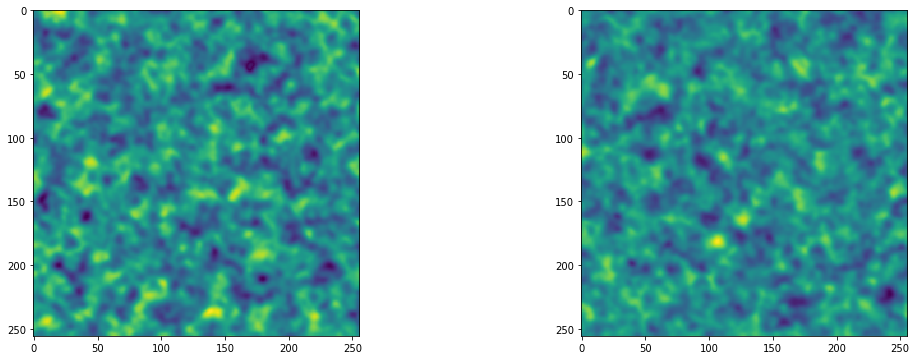

Step 1000, Total loss 327898.187500

time elapsed: 119.22717690467834


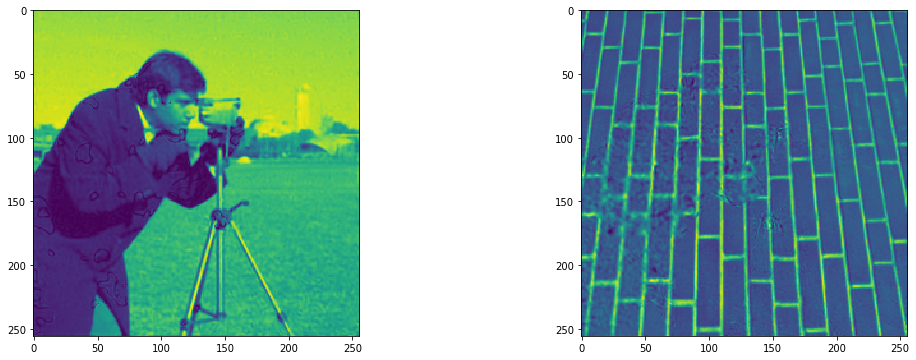

Step 1999, Total loss 123575.992188

time elapsed: 215.81834506988525


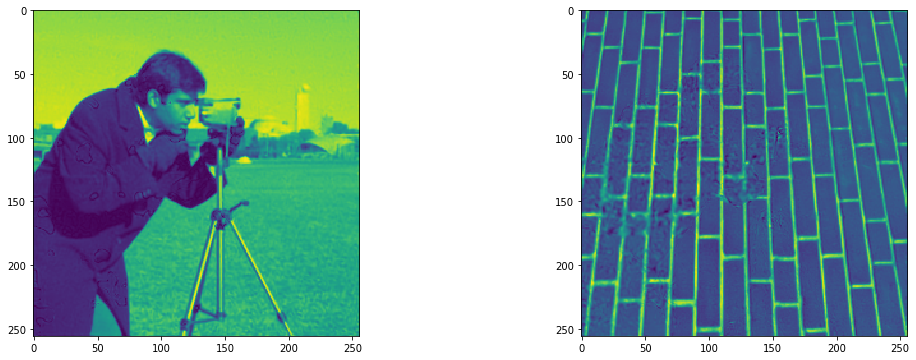

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
psnr_amp,▁▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
psnr_pha,▁▃▃▃▃▃▃▂▃▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████████████
ssim_amp,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
ssim_pha,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████
loss,123575.99219
psnr_amp,27.94314
psnr_pha,24.58634
ssim_amp,0.92723
ssim_pha,0.89146



time elapsed: 72.23762607574463


In [22]:
t0 = time.time()
twandb = 0

for step in range(total_steps):
    model_output, coords = model(model_input)
    model_output =model_output.reshape(num_scan, -1, 2)

    density=model_output[:,:,0]
    density= abs(density)
    phase=model_output[:,:,1]
    density=density.view(num_scan,28,28)
    phase=phase.view(num_scan,28,28)
    Predicted_Object=torch.complex(density*torch.cos(phase*np.pi),density*torch.sin(phase*np.pi))
    
    Prediction=torch.mul(Predicted_Object, probe)
    Prediction = torch.fft.fft2(Prediction, dim=(-2,-1))
    P_Intensity = torch.fft.fftshift(Prediction, dim=(-2, -1))
    P_phase = P_Intensity.angle()
    P_Intensity = torch.abs(P_Intensity)
    inten = scan_wrap[0]['meas_inten'].cuda()
    Updated_Intensity=get_new_intensity(P_phase,inten.float(),probe)
    intenloss = criterion(P_Intensity.float(), inten.float())
    phaloss = criterion(Updated_Intensity.float(),inten.float())
    
    loss = 0.3*criterion(P_Intensity.float(), inten.float())+0.7*criterion(Updated_Intensity.float(),inten.float())
    
    t = time.time()
    model_output_, coords = model(model_input_l)
    density_=model_output_[:,0]
    density_= abs(density_)
    phase_=model_output_[:,1]
    density_=density_.view(1,h,h)[:,pad:-pad,pad:-pad]
    phase_=phase_.view(1,h,h)[:,pad:-pad,pad:-pad]

    psnr_amp, psnr_pha, ssim_amp, ssim_pha, reg_amp_best, reg_pha_best = evaluate(density_.cpu(),
                                                                                      phase_.cpu(),
                                                                                      real_density,
                                                                                      real_phase,
                                                                                      256)
    
    wandb.log({"loss": loss, "psnr_amp": np.mean(np.asarray(psnr_amp.detach().numpy())),
               "psnr_pha": np.mean(np.asarray(psnr_pha.detach().numpy())),
               "ssim_amp": np.mean(np.asarray(ssim_amp.detach().numpy())),
               "ssim_pha": np.mean(np.asarray(ssim_pha.detach().numpy()))})
    t1 = time.time()
    twandb = twandb + t1 - t

    if (not step % 1000) or (step==total_steps-1):
        print("Step %d, Total loss %0.6f" % (step, loss))
        print('\ntime elapsed:',t1-t0)
        fig, axes = plt.subplots(1,2, figsize=(18,6))
        axes[0].imshow(density_.permute(1,2,0).cpu().detach().numpy(), interpolation='nearest')
        axes[1].imshow(phase_.permute(1,2,0).cpu().detach().numpy(), interpolation='nearest')
        plt.show()
        t = time.time()
        image_array = np.hstack([real_density[0], reg_amp_best.copy()])
        images = wandb.Image(
            image_array,
            caption="Left: GT, Right: Estimation"
        )
        wandb.log({"Amplitude": images})

        image_array = np.hstack([real_phase[0], torch.from_numpy(reg_pha_best.copy())])
        images = wandb.Image(
            image_array,
            caption="Left: GT, Right: Estimation"
        )
        wandb.log({"Phase": images})
        t1 = time.time()
        twandb = twandb + t1 - t

    if loss < min_loss:
        min_loss = loss
        best_density = density_
        best_phase = phase_
        t = time.time()
        psnr_amp_, psnr_pha_, ssim_amp_, ssim_pha_, reg_amp_best_, reg_pha_best_ = evaluate(density_.cpu(),
                                                                                      phase_.cpu(),
                                                                                      real_density,
                                                                                      real_phase,
                                                                                      256)
        t1 = time.time()
        twandb = twandb + t1 - t

    optim.zero_grad()
    loss.backward()
    optim.step()
t = time.time()
images = wandb.Image(
    reg_amp_best_,
)
wandb.log({"Amplitude": images})

images = wandb.Image(
    reg_pha_best_,
)
wandb.log({"Phase": images})
wandb.finish()
t1=time.time()
twandb = twandb + t1-t
t1 = time.time()
print('\ntime elapsed:',t1-t0-twandb)
torch.save(model.state_dict(), './ptymodel/SIREN_'+str(overlap)+'.pt')

In [23]:
psnr_amp_, psnr_pha_, ssim_amp_, ssim_pha_

(tensor(27.9431), tensor(24.5863), tensor(0.9272), tensor(0.8915))